# Stan Implementation of the model

In the paper, the maximum marginal likelihood is used to select the scale for the random walk scale. This notebook uses a model where a hyperprior is placed on the random walk scale instead:

$$\sigma_{rw} \sim \mathcal{N}^+(5)$$

For inference, I use NUTS instead of SMC.

## 1. Preprocess the data

I'll just use the same example as in `quick_start.ipynb`.

In [23]:
import pandas as pd

ltla = "Thurrock"
report_dt = "2020-12-14"

df = pd.read_csv(f"../data/cases-{report_dt}.csv"
                ).query(f"`Area name` == '{ltla}' & `Area type` == 'ltla'")
df = df.sort_values('Specimen date')

ys_sequence = df['Daily lab-confirmed cases'].values[-14:]
is_weekend = (pd.to_datetime(df["Specimen date"]).dt.weekday >= 5).astype(int).values[-14:]

In [24]:
import sys
sys.path.append("..")

from data_processing.data import get_data, moment_match_theta_priors
from datetime import timedelta

last_report_dt = pd.to_datetime(report_dt)
report_dates = pd.date_range(start=last_report_dt - timedelta(14), end=last_report_dt)

historical_df = get_data(ltla, report_dates=report_dates)
alphas, betas = moment_match_theta_priors(historical_df, n_lags=len(ys_sequence))

../data_processing/data.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row[clcc] = np.nan


## 2. Fit the model

Stan grumbles a bit that $\lambda$ can become negative sometimes because the AR(1) process can easily walk in that direction - a future version of this model might do this on the log scale instead.

In [54]:
import pystan

model = pystan.StanModel("../stan_models/nowcast.stan")
data = {"n_days": len(ys_sequence), "y": ys_sequence, "a": alphas, "b": betas, "is_weekend": is_weekend}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2426a300b75cb48511004d7ed2bc6a1a NOW.


In [71]:
fit = model.sampling(data)

The Rhat warning here is because some elements of `z` have zero variance because they are deterministically set to 1, meaning Rhat is undefined.

## 3. Plots

In [72]:
import matplotlib.pyplot as plt
import numpy as np

def plot_posterior(samples, name=None):
    # plot the posterior mean and 95% credible interval
    mean = samples.mean(axis=0)
    lo = np.percentile(samples, 2.5, axis=0)
    hi = np.percentile(samples, 97.5, axis=0)
    
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.fill_between(np.arange(samples.shape[1]), lo, hi, color="xkcd:sky blue")
    ax.plot(mean, c="xkcd:denim blue", lw=3, label="" or name)
    
    return ax 

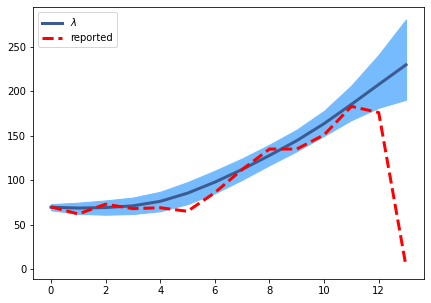

In [73]:
ax = plot_posterior(fit["lambda"], name="$\lambda$")
ax.plot(ys_sequence, c="r", ls="--", lw=3, label="reported")
ax.legend(loc="upper left");

Bit of a tick down in the posterior at the start for some reason - gamma prior not working as expected?

Posterior on random walk scale:

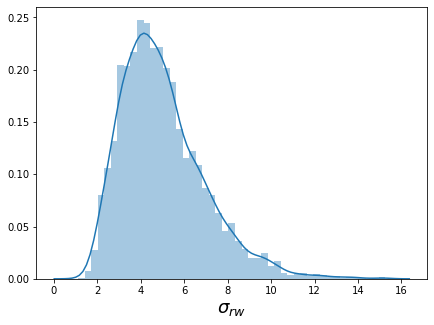

In [74]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(7, 5))
sns.distplot(fit["sigma_rw"], ax=ax)
ax.set_xlabel("$\sigma_{rw}$", size=18);

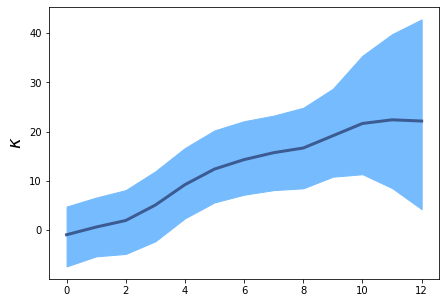

In [75]:
ax = plot_posterior(fit["kappa"])
ax.set_ylabel("$\kappa$", size=18);

Dip because I didn't include weekend effect?

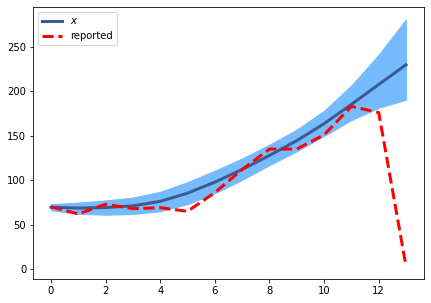

In [76]:
ax = plot_posterior(fit["lambda"], name="$x$")
ax.plot(ys_sequence, c="r", ls="--", lw=3, label="reported")
ax.legend(loc="upper left");